<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/Model_Tuning_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variance-Bias Trade-Off

The code below simulates one predictor (`x`) and one response variable (`y`). The relationship between `x` and `fx` is non-linear.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotnine import *
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

In [ ]:
# randomly simulate some non-linear samples
x = np.arange(1, 10, 0.01) * np.pi
e = np.random.normal(0, 0.2, len(x))
y = np.sin(x) + e + x**0.5
dat = pd.DataFrame({'x': x, 'y': y})

Then fit a simple linear regression on these data:

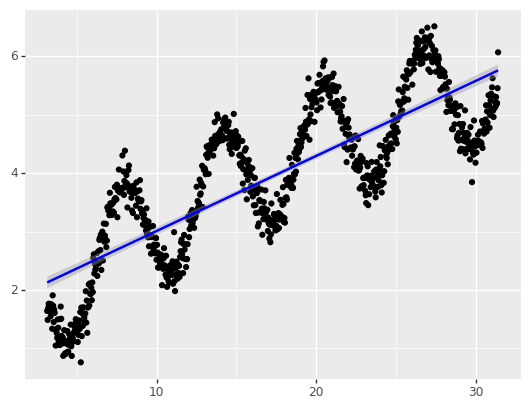

<ggplot: (-9223363282065725538)>

In [ ]:
(    ggplot(dat, aes(x='x', y='y'))
    + geom_point()
    + geom_smooth(method = 'lm', color = 'blue')
    + xlab('')
    + ylab('')
)

Let’s fit the above data using a smoothing method which is highly flexible and can fit the current data tightly:

/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


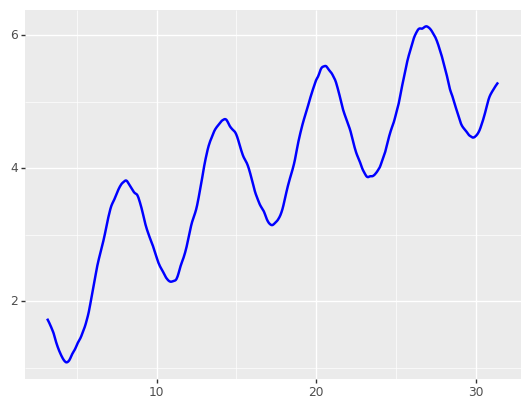

<ggplot: (-9223363282065791800)>

In [ ]:
(    ggplot(dat, aes(x='x', y='y'))
    + geom_smooth(span=.03, color = 'blue')
    + xlab('')
    + ylab('')
)

The resulting plot indicates the smoothing method fit the data much better and it has a much smaller bias. However, this method has a high variance. If we simulate different subsets of the sample, the result curve will change significantly:


/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


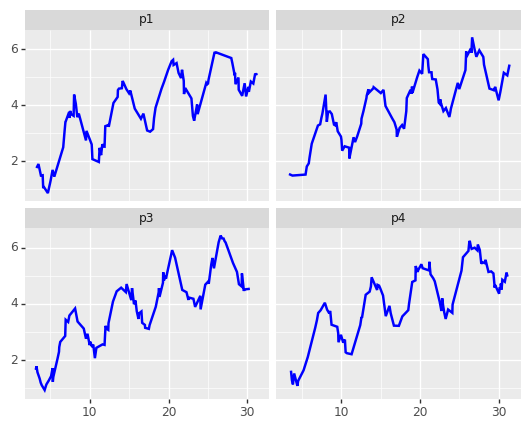

<ggplot: (-9223363282065699370)>

In [ ]:
random.seed(100)
 
# sample part of the data to fit model sample 1
p1 = dat.sample(100)
p1['group'] = 'p1'
p2 = dat.sample(100)
p2['group'] = 'p2'
p3 = dat.sample(100)
p3['group'] = 'p3'
p4 = dat.sample(100)
p4['group'] = 'p4'
pdat = pd.concat([p1,p2,p3,p4])
 
(    ggplot(pdat, aes(x='x', y='y'))
    + geom_smooth(span=.03, color = 'blue')
    + xlab('')
    + ylab('')
    + facet_wrap('group')
)

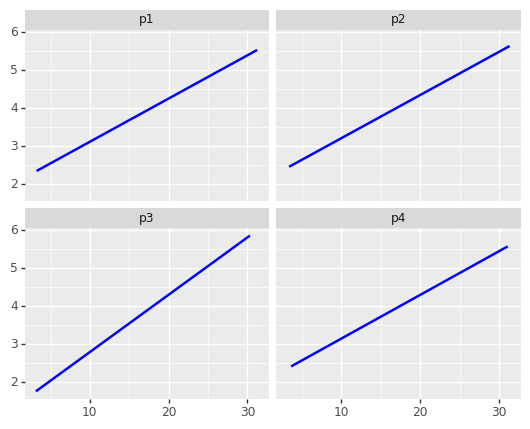

<ggplot: (-9223363282065862063)>

In [ ]:
(    ggplot(pdat, aes(x='x', y='y'))
    + geom_smooth(method = 'lm', color = 'blue', se = False)
    + xlab('')
    + ylab('')
    + facet_wrap('group')
)

# Data Splitting and Resampling

You can use `sklearn` to perform data splitting and resampling. Some key functions:

- `train_test_split`: creates single split into train and test set.
- `Kfold`: creates k-fold splits allowing cross validation
- `StratifiedKFold`:  creates k-fold splits considering the distribution of the target variable
- `cross_val_score`: evaluta model's score through cross validation



## Data Splitting


In [ ]:
# load data
sim_dat = pd.read_csv("http://bit.ly/2P5gTw4")
sim_dat.head()

,age,gender,income,house,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,segment
0,57,Female,120963.400958,Yes,529.134363,303.512475,2,2,4,2,1,2,1,4,1,4,2,4,Price
1,63,Female,122008.104950,Yes,478.005781,109.529710,4,2,4,1,1,2,1,4,1,4,1,4,Price
2,59,Male,114202.295294,Yes,490.810731,279.249582,7,2,5,2,1,2,1,4,1,4,1,4,Price
3,60,Male,113616.337078,Yes,347.809004,141.669752,10,2,5,2,1,3,1,4,1,4,2,4,Price
4,51,Male,124252.552787,Yes,379.625940,112.237177,4,4,4,1,1,3,1,4,1,4,2,4,Price


In [ ]:
# set random seed to make sure reproducibility
np.random.seed(3456)

train, test = train_test_split(sim_dat, test_size = 0.2, stratify = sim_dat.segment)

In [ ]:
## Training Data
counts = train.segment.value_counts().rename('counts')
p = train.segment.value_counts(normalize=True).rename('p')
pd.concat([counts, p], axis=1)

,counts,p
Style,280,0.35
Price,200,0.25
Quality,160,0.20
Conspicuous,160,0.20


In [ ]:
## Testing Data
counts = test.segment.value_counts().rename('counts')
p = test.segment.value_counts(normalize=True).rename('p')
pd.concat([counts, p], axis=1)

,counts,p
Style,70,0.35
Price,50,0.25
Quality,40,0.20
Conspicuous,40,0.20


Let's perform random forest using the above `train` and `test` data. 

In [ ]:
# initialize the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators = 500, max_features = 2)
train_x = train.filter(regex = "^store")
train_y = train.segment

test_x = test.filter(regex = "^store")
test_y = test.segment
rf_fit = rf.fit(train_x, train_y)
pred_y = rf_fit.predict(test_x)

# check the auc on test set
accuracy_score(test_y, pred_y)

0.935

## Resampling


###  k-fold cross-validation

k-fold cross-validation is to partition the original sample into  k equal size subsamples (folds). Use `KFold` from `sklearn.model_selection` to do this. Kfold method returns the order of the samples chosen for train and test sets in each fold. On a pandas dataframe we have use to `.iloc` function to get the correct rows. Because we haven't split the data into x (predictors) and y (response), we need to select the columns (`.filter(regex = "^store")` and we use the two variables related to store purchases) or simply pick the columns (`.segment`).

In [ ]:
# KFold function has to be applied on the data and it returns an location (index) of the train and test samples.
kf = KFold(n_splits=10, shuffle=True, random_state= 2000) 
i = 1
for train_index, test_index in kf.split(sim_dat):
  train_x = sim_dat.iloc[train_index].filter(regex = "^store")
  train_y = sim_dat.iloc[train_index].segment
  test_x = sim_dat.iloc[test_index].filter(regex = "^store")
  test_y = sim_dat.iloc[test_index].segment

  #Train the model
  rf_fit = rf.fit(train_x, train_y) #Training the model
  pred_y = rf_fit.predict(test_x)
  print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(test_y, pred_y)}")
  i += 1


Accuracy for the fold no. 1 on the test set: 0.93
Accuracy for the fold no. 2 on the test set: 0.89
Accuracy for the fold no. 3 on the test set: 0.96
Accuracy for the fold no. 4 on the test set: 0.95
Accuracy for the fold no. 5 on the test set: 0.96
Accuracy for the fold no. 6 on the test set: 1.0
Accuracy for the fold no. 7 on the test set: 0.94
Accuracy for the fold no. 8 on the test set: 0.93
Accuracy for the fold no. 9 on the test set: 0.94
Accuracy for the fold no. 10 on the test set: 0.96


###  Stratified k-fold cross-validation

We can use `StratifiedKFold`, which needs an extra parameter `stratify`. This is the response variable. Stratified k-fold picks balanced distribution of the response categories in each fold.


In [ ]:
kf = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 2000)

i = 1
for train_index, test_index in kf.split(sim_dat, sim_dat.segment):
  train_x = sim_dat.iloc[train_index].filter(regex = "^store")
  train_y = sim_dat.iloc[train_index].segment
  test_x = sim_dat.iloc[test_index].filter(regex = "^store")
  test_y = sim_dat.iloc[test_index].segment

  #Train the model
  rf_fit = rf.fit(train_x, train_y) #Training the model
  pred_y = rf_fit.predict(test_x)
  print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(test_y, pred_y)}")
  i += 1

Accuracy for the fold no. 1 on the test set: 0.92
Accuracy for the fold no. 2 on the test set: 0.93
Accuracy for the fold no. 3 on the test set: 0.92
Accuracy for the fold no. 4 on the test set: 0.99
Accuracy for the fold no. 5 on the test set: 0.95
Accuracy for the fold no. 6 on the test set: 0.93
Accuracy for the fold no. 7 on the test set: 0.97
Accuracy for the fold no. 8 on the test set: 0.95
Accuracy for the fold no. 9 on the test set: 0.95
Accuracy for the fold no. 10 on the test set: 0.96


We can see that each fold's accuracy is more consistent when we use stratified k-fold cross-validation compared to the random k-fold cross-validation. 

### Shuffle & Split

We can use `ShuffleSplit` to repeat the training/test set division on the original data. Samples are first shuffled and then split into a pair of train and test sets.

In [ ]:
ss = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 2000)
i = 1
for train_index, test_index in ss.split(sim_dat):
  train_x = sim_dat.iloc[train_index].filter(regex = "^store")
  train_y = sim_dat.iloc[train_index].segment
  test_x = sim_dat.iloc[test_index].filter(regex = "^store")
  test_y = sim_dat.iloc[test_index].segment

  #Train the model
  rf_fit = rf.fit(train_x, train_y) #Training the model
  pred_y = rf_fit.predict(test_x)
  print(f"Accuracy for the split no. {i} on the test set: {accuracy_score(test_y, pred_y)}")
  i += 1

Accuracy for the split no. 1 on the test set: 0.92
Accuracy for the split no. 2 on the test set: 0.925
Accuracy for the split no. 3 on the test set: 0.9
Accuracy for the split no. 4 on the test set: 0.965
Accuracy for the split no. 5 on the test set: 0.93
